# Task 4 Time Series Analysis
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to extract the time series


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax, TimeSeriesResampler
from statsmodels.tsa.stattools import adfuller 

In [104]:
df = pd.read_csv("../dataset/cleaned_joined_tweets.csv", index_col = 0) 
del df['lang']
del df['bot']
del df['text']
del df['created_at_user']
del df['statuses_count']
del df['id'] #of the tweet

c:\Users\giaco\anaconda3\envs\PythonGPU\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [105]:
df.created_at = pd.to_datetime(df.created_at, errors='ignore').astype('datetime64[D]')
df.sort_values(by=['user_id', 'created_at'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4722646 entries, 4499433 to 4080317
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   retweet_count   int64         
 2   reply_count     int64         
 3   favorite_count  int64         
 4   num_hashtags    int64         
 5   num_urls        int64         
 6   num_mentions    int64         
 7   created_at      datetime64[ns]
dtypes: datetime64[ns](1), int64(7)
memory usage: 324.3 MB


Get only the tweets in 2019:

In [106]:
min_date = np.datetime64('2019-01-01 00:00:00')
max_date = np.datetime64('2019-12-31 23:59:59')

df_2019 = df[(df.created_at > min_date) & (df.created_at < max_date)].copy()

For each user we define a series of 365 values initialized at -1, so we define a dataframe of Number_of_users * 365

In [107]:
df_2019.head()

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at
3343007,722623,1,0,0,0,0,2,2019-01-03
3343357,722623,0,0,2,0,0,0,2019-01-03
3343475,722623,0,0,0,0,0,0,2019-01-03
3343674,722623,0,0,0,0,0,0,2019-01-03
3344173,722623,3,0,0,0,0,1,2019-01-03


## Extract timeseries

### Use pivoting

In [108]:
user_2019 = df_2019.groupby(['user_id', 'created_at']).sum()

Is possible to perform the following operation, sicne in the data cleaning we filled the NaN values.

In [109]:
user_2019['success_score'] = (user_2019.retweet_count + user_2019.reply_count + user_2019.favorite_count) / (user_2019.num_hashtags + user_2019.num_urls + user_2019.num_mentions + 0.1)

Deleting the columns used for the calculation

In [110]:
del user_2019['retweet_count']
del user_2019['reply_count']
del user_2019['favorite_count']
del user_2019['num_hashtags']
del user_2019['num_urls']
del user_2019['num_mentions']

In [111]:
user_2019 = user_2019.pivot_table('success_score','created_at','user_id')
user_2019.rename_axis(columns=None, inplace=True)
user_2019.reset_index(drop=False, inplace=True)

In [112]:
dates = pd.Series(pd.date_range('01-01-2019','31-12-2019')).rename('created_at')

user_2019 = user_2019.merge(dates, how='outer', on='created_at')
user_2019.fillna(-1, inplace=True)
user_2019.set_index('created_at', inplace=True)
user_2019.sort_index(inplace=True)

In [113]:
user_2019.head()

,722623,755746,5812422,8657052,9272142,12287842,13126372,14290542,14391111,14558848,...,2469738596,2492782375,2497379616,2505222079,2528822924,2596494170,2599346388,2615998837,2619891104,2680793168
created_at,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-1.000000,-1.0,-1.00000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-02,-1.000000,-1.0,-1.00000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-03,1.549296,0.0,0.10989,-1.0,-1.0,-1.000000,-1.000000,107.024030,0.243902,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-04,1626.393443,0.0,4.83871,-1.0,-1.0,99.503546,0.392157,39.321267,0.476190,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-05,1.818182,0.0,0.00000,-1.0,-1.0,0.000000,0.000000,415.352113,0.952381,20.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [114]:
user_2019.to_csv('../dataset/time_series.csv')

## Preprocessing

### Detect and Remove trends

In [171]:
# Augmented Dickey-Fuller test
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
non_stationary_idx_list = []

for col in user_2019.columns:
    adf = adfuller(user_2019[col])
    pvalue = adf[1]
    if pvalue > 0.05:
        non_stationary_idx_list.append(col)

c:\Users\giaco\anaconda3\envs\PythonGPU\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [172]:
len(non_stationary_idx_list)

0

In [161]:
# Augmented Dickey-Fuller test of example of non sationary timeseries found before
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
adf = adfuller(user_2019[non_stationary_idx_list[14]])
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -2.828828939207841
p-value: 0.05427229497015501
Critical values:
1%: -3.449336554273722
5%: -2.8699055166063085
10%: -2.571226758215748


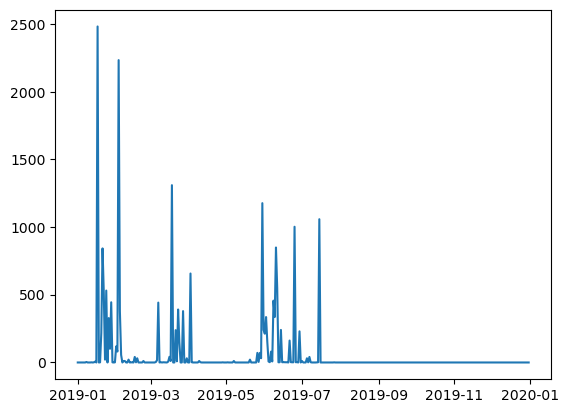

In [158]:
plt.plot(user_2019[non_stationary_idx_list[14]])
plt.show()

Trend removal

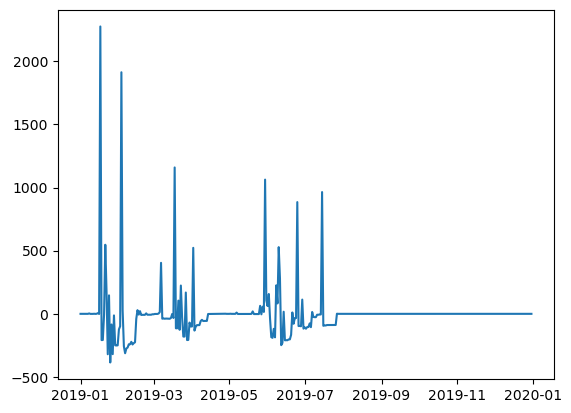

In [166]:
ts_example = user_2019[non_stationary_idx_list[14]]

ts_shift = ts_example - ts_example.rolling(window=12, min_periods=1).mean()
plt.plot(ts_shift)
plt.show()

In [169]:
# Augmented Dickey-Fuller test of example of timeseries after trend removal
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
adf = adfuller(ts_shift)
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -5.111788056262019
p-value: 1.3273697292755686e-05
Critical values:
1%: -3.4492815848836296
5%: -2.8698813715275406
10%: -2.5712138845950587


Remove trends for all timeseries with trend

In [170]:
user_2019_detrend = user_2019.copy()

for col in non_stationary_idx_list:
    user_2019_detrend[col] = user_2019_detrend[col] - user_2019_detrend[col].rolling(window=12, min_periods=1).mean()

### Noise detection
(prova diverse window)

(365,)


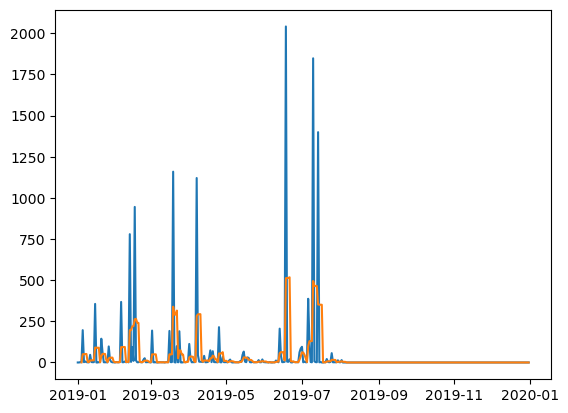

In [119]:
ts_example = user_2019.iloc[:, 29]

print(np.shape(ts_example))

plt.plot(ts_example)
plt.plot(ts_example.rolling(window=4).mean())
plt.show()

### Scaler

#### Mean Variance

In [120]:
#scaler mean variance
user_2019_std = pd.DataFrame()
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  
for col in user_2019.columns:
    user_2019_std[col] = scaler.fit_transform(user_2019[col].values.reshape(1, -1)).flatten()

ts_example_1 = user_2019_std.iloc[:, 29]
ts_example_2 = user_2019_std.iloc[:, 567]
ts_example_3 = user_2019_std.iloc[:, 1000]
ts_example_4 = user_2019_std.iloc[:, 867]
plt.plot(ts_example_1)
plt.plot(ts_example_2)
plt.plot(ts_example_3)
plt.plot(ts_example_4)
plt.show()

IndexError: index 722623 is out of bounds for axis 0 with size 365

In [ ]:
user_2019.head()

### Resample ??

## Clustering timeseries